### Using recurrent neural networks for the analysis of behavioural data
##### Amir Dezfouli

### Background
In this tutorial, I will present how to use recurrent neural networks (RNNs) for the analysis of behavioural data. In this setting, we have the behaviour of a set of subjects in a task and the aim is to have a computational model for the subjects' choice processes. This kind of data is often analysed using reinforcement-learning models such as Q-learning. A potential problem with this approach is that the model development is mainly intuition-driven and the model needs to be manually engineered to match the actual underlying behavioural trends in the data. RNNs, on the other hand, are flexible and fit the data <i>automatically</i> without requiring engineering, but they may be hard to interpret. In [this paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006903), we showed that RNNs provide a better fit to the data compared to the baseline reinforcement-learning models. The code of the paper is available in this [link](https://github.com/adezfouli/rnn_beh), using `Tensorflow==1.3`. In this tutorial, I will show how to fit a recurrent neural network to the behavioural data using `Tensroflow 2` and `keras`, which are easier to work with compared to the earlier versions of `Tensroflow`.

### Recurrent neural networks
The model is composed of a set of RNN cells, which then through a softmax layer make predictions for the probability of selecting each action in the next trial. In the context of the behavioural data that we are interested in, at each trial $t$, the model takes the previous action $a_{t-1}$, the reward received by taking the action ($r_{t-1}$), and the current state of the world ($s_t$) as an input, and then produces predictions for the probability of taking each action in the next trial. For example, in the case of binary bandits with two actions, the model predicts the probability of taking action L and R. The predictions of the model are then used to build a loss function $\mathcal{L}$ , which is used to train the model. Note that in the case of bandit tasks there is no state information.

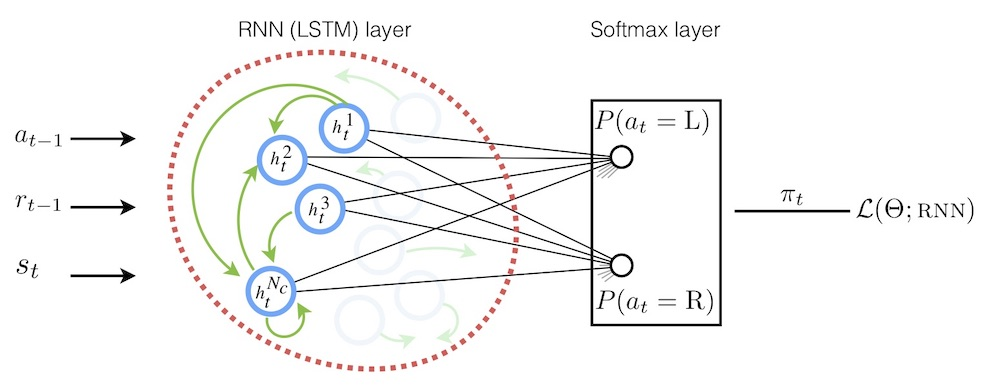

### Requirements
The code is based on `tensorflow==2.0.0-beta1`. See [here](https://www.tensorflow.org/install/pip) for the details of installation. For loading data `h5py` pakcage is used which can be installed using `pip`.


### Loading and preparing data
The data is in file `data/BD-healthy.hdf5`,

In [155]:
import h5py
import numpy as np
with h5py.File('data/BD-healthy.hdf5', 'r') as f:
    # loading actions taken by the subjects
    action = f['action'][:].astype(np.int32)
    
    # loading rewards received by the subjects
    reward = f['reward'][:].astype(np.float32)

`action` and `reward` are both matrices with S x T dimensions, in which S is the number of subjects and T is the number of trials. Actions are coded as integers (0, 1, ...). The number of completed trials can be different for each subject, in which case the actions at the empty trials at the end of the task are coded by -1. 

We convert the actions into one-hot format,

In [156]:
from tensorflow import one_hot
action = one_hot(action, 2) # action 0 is coded as [1, 0], and action 1 is coded as [0, 1], and -1 is coded as [0, 0]

Actions and rewards are then concatenated to form the input to the model. Note that a dummy action and reward is added to the beginning of the data,

In [157]:
from tensorflow.python.keras.layers import Concatenate, ZeroPadding1D
action_reward = Concatenate(axis=2)([reward[:, :, np.newaxis], action])

# adding dummy zero to the beginning and ignoring the last one
action_reward = ZeroPadding1D(padding=[1, 0])(action_reward)[:, :-1, :]


### Defining the model
We first define the model. For simplicity we focus on the modelling of bandit tasks, in which there is no state information and therefore the model only receives input $a_{t-1}$ and $r_{t-1}$,

In [158]:
import tensorflow as tf
import tensorflow.keras.layers as kl

n_actions = 2    # there are two actions
state_size = 0   # there is only state in the bandit task, so we don't pass the state information to the model
n_cells = 5      # number of cells in the recurrent neural network

# inputs to the model. Dim: S x T x (1 + n_actions + state_size).
model_inputs = tf.keras.Input(shape=(None, 1 + n_actions + state_size), name='action_reward')

# initial state of the RNN, Dim: S x n_cells
rnn_initial_state = tf.keras.Input(shape=(n_cells,), name='initial_state')

# output of the recurrent nerual network. Dim: S x T x n_cells
rnn_out = kl.GRU(n_cells, return_sequences=True, name='GRU')(model_inputs, initial_state=rnn_initial_state)

# policy -- probablity of taking each action. Dim: S x T x n_actions
policy = kl.Dense(n_actions, activation='softmax', name='policy')(rnn_out)

# defining the model
model = tf.keras.Model(inputs=[model_inputs, rnn_initial_state], outputs=policy, name='model')

model.save('model.h5')

### Optimising the model

In [159]:
import tensorflow as tf
import tensorflow.keras.backend as kb
from tensorflow.python.keras.losses import categorical_crossentropy

# defining the optimiser
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

# initial state of RNN
initial_rnn_state = np.zeros((action_reward.shape[0], n_cells,), dtype=np.float32)

# defining loss
def loss(y_true, y_pred):
    return kb.sum(categorical_crossentropy(y_true, y_pred))


model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# training the model
model.fit([action_reward, initial_rnn_state], action, epochs=2000, batch_size=action_reward.shape[0])



Train on 408 samples
Epoch 1/2000
408/408 [==============================] - 0s 1ms/sample - loss: 31755.4414 - accuracy: 0.2926
Epoch 2/2000
408/408 [==============================] - 0s 142us/sample - loss: 30222.0586 - accuracy: 0.2993
Epoch 3/2000
408/408 [==============================] - 0s 138us/sample - loss: 28943.3984 - accuracy: 0.3484
Epoch 4/2000
408/408 [==============================] - 0s 138us/sample - loss: 27892.0254 - accuracy: 0.5310
Epoch 5/2000
408/408 [==============================] - 0s 140us/sample - loss: 27014.5547 - accuracy: 0.5301
Epoch 6/2000
408/408 [==============================] - 0s 142us/sample - loss: 26247.1875 - accuracy: 0.5302
Epoch 7/2000
408/408 [==============================] - 0s 142us/sample - loss: 25537.6484 - accuracy: 0.5293
Epoch 8/2000
408/408 [==============================] - 0s 144us/sample - loss: 24850.7441 - accuracy: 0.5229
Epoch 9/2000
408/408 [==============================] - 0s 139us/sample - loss: 24166.8945 - accuracy

Epoch 75/2000
408/408 [==============================] - 0s 148us/sample - loss: 13517.9873 - accuracy: 0.5412
Epoch 76/2000
408/408 [==============================] - 0s 145us/sample - loss: 13505.2588 - accuracy: 0.5412
Epoch 77/2000
408/408 [==============================] - 0s 142us/sample - loss: 13492.6133 - accuracy: 0.5412
Epoch 78/2000
408/408 [==============================] - 0s 140us/sample - loss: 13480.0176 - accuracy: 0.5412
Epoch 79/2000
408/408 [==============================] - 0s 136us/sample - loss: 13467.4336 - accuracy: 0.5412
Epoch 80/2000
408/408 [==============================] - 0s 144us/sample - loss: 13454.8369 - accuracy: 0.5412
Epoch 81/2000
408/408 [==============================] - 0s 144us/sample - loss: 13442.2070 - accuracy: 0.5412
Epoch 82/2000
408/408 [==============================] - 0s 147us/sample - loss: 13429.5332 - accuracy: 0.5412
Epoch 83/2000
408/408 [==============================] - 0s 144us/sample - loss: 13416.8164 - accuracy: 0.5411
E

Epoch 149/2000
408/408 [==============================] - 0s 133us/sample - loss: 12605.3350 - accuracy: 0.5544
Epoch 150/2000
408/408 [==============================] - 0s 136us/sample - loss: 12593.6895 - accuracy: 0.5546
Epoch 151/2000
408/408 [==============================] - 0s 140us/sample - loss: 12582.1680 - accuracy: 0.5546
Epoch 152/2000
408/408 [==============================] - 0s 138us/sample - loss: 12570.7676 - accuracy: 0.5553
Epoch 153/2000
408/408 [==============================] - 0s 137us/sample - loss: 12559.4893 - accuracy: 0.5556
Epoch 154/2000
408/408 [==============================] - 0s 145us/sample - loss: 12548.3301 - accuracy: 0.5557
Epoch 155/2000
408/408 [==============================] - 0s 141us/sample - loss: 12537.2852 - accuracy: 0.5555
Epoch 156/2000
408/408 [==============================] - 0s 143us/sample - loss: 12526.3477 - accuracy: 0.5555
Epoch 157/2000
408/408 [==============================] - 0s 142us/sample - loss: 12515.5146 - accuracy:

Epoch 223/2000
408/408 [==============================] - 0s 144us/sample - loss: 11961.5137 - accuracy: 0.5971
Epoch 224/2000
408/408 [==============================] - 0s 148us/sample - loss: 11956.1035 - accuracy: 0.6067
Epoch 225/2000
408/408 [==============================] - 0s 139us/sample - loss: 11950.7598 - accuracy: 0.9210
Epoch 226/2000
408/408 [==============================] - 0s 138us/sample - loss: 11945.4824 - accuracy: 0.9267
Epoch 227/2000
408/408 [==============================] - 0s 135us/sample - loss: 11940.2656 - accuracy: 0.9293
Epoch 228/2000
408/408 [==============================] - 0s 133us/sample - loss: 11935.1074 - accuracy: 0.9323
Epoch 229/2000
408/408 [==============================] - 0s 135us/sample - loss: 11930.0078 - accuracy: 0.9333
Epoch 230/2000
408/408 [==============================] - 0s 143us/sample - loss: 11924.9668 - accuracy: 0.9340
Epoch 231/2000
408/408 [==============================] - 0s 135us/sample - loss: 11919.9785 - accuracy:

Epoch 297/2000
408/408 [==============================] - 0s 144us/sample - loss: 11670.2285 - accuracy: 0.9445
Epoch 298/2000
408/408 [==============================] - 0s 148us/sample - loss: 11667.1367 - accuracy: 0.9444
Epoch 299/2000
408/408 [==============================] - 0s 148us/sample - loss: 11664.0498 - accuracy: 0.9444
Epoch 300/2000
408/408 [==============================] - 0s 153us/sample - loss: 11660.9629 - accuracy: 0.9445
Epoch 301/2000
408/408 [==============================] - 0s 145us/sample - loss: 11657.8779 - accuracy: 0.9445
Epoch 302/2000
408/408 [==============================] - 0s 147us/sample - loss: 11654.7900 - accuracy: 0.9445
Epoch 303/2000
408/408 [==============================] - 0s 147us/sample - loss: 11651.7012 - accuracy: 0.9442
Epoch 304/2000
408/408 [==============================] - 0s 149us/sample - loss: 11648.6094 - accuracy: 0.9442
Epoch 305/2000
408/408 [==============================] - 0s 162us/sample - loss: 11645.5107 - accuracy:

Epoch 371/2000
408/408 [==============================] - 0s 195us/sample - loss: 11490.2051 - accuracy: 0.9466
Epoch 372/2000
408/408 [==============================] - 0s 169us/sample - loss: 11488.8730 - accuracy: 0.9466
Epoch 373/2000
408/408 [==============================] - 0s 155us/sample - loss: 11487.5479 - accuracy: 0.9466
Epoch 374/2000
408/408 [==============================] - 0s 142us/sample - loss: 11486.2275 - accuracy: 0.9466
Epoch 375/2000
408/408 [==============================] - 0s 142us/sample - loss: 11484.9141 - accuracy: 0.9466
Epoch 376/2000
408/408 [==============================] - 0s 142us/sample - loss: 11483.6074 - accuracy: 0.9466
Epoch 377/2000
408/408 [==============================] - 0s 158us/sample - loss: 11482.3066 - accuracy: 0.9466
Epoch 378/2000
408/408 [==============================] - 0s 186us/sample - loss: 11481.0117 - accuracy: 0.9466
Epoch 379/2000
408/408 [==============================] - 0s 162us/sample - loss: 11479.7246 - accuracy:

Epoch 445/2000
408/408 [==============================] - 0s 146us/sample - loss: 11401.1455 - accuracy: 0.9468
Epoch 446/2000
408/408 [==============================] - 0s 144us/sample - loss: 11399.9824 - accuracy: 0.9468
Epoch 447/2000
408/408 [==============================] - 0s 170us/sample - loss: 11398.8203 - accuracy: 0.9468
Epoch 448/2000
408/408 [==============================] - 0s 150us/sample - loss: 11397.6582 - accuracy: 0.9468
Epoch 449/2000
408/408 [==============================] - 0s 145us/sample - loss: 11396.4932 - accuracy: 0.9468
Epoch 450/2000
408/408 [==============================] - 0s 148us/sample - loss: 11395.3301 - accuracy: 0.9469
Epoch 451/2000
408/408 [==============================] - 0s 146us/sample - loss: 11394.1660 - accuracy: 0.9469
Epoch 452/2000
408/408 [==============================] - 0s 151us/sample - loss: 11393.0020 - accuracy: 0.9469
Epoch 453/2000
408/408 [==============================] - 0s 149us/sample - loss: 11391.8359 - accuracy:

Epoch 519/2000
408/408 [==============================] - 0s 140us/sample - loss: 11313.9365 - accuracy: 0.9467
Epoch 520/2000
408/408 [==============================] - 0s 140us/sample - loss: 11312.7676 - accuracy: 0.9467
Epoch 521/2000
408/408 [==============================] - 0s 140us/sample - loss: 11311.5977 - accuracy: 0.9467
Epoch 522/2000
408/408 [==============================] - 0s 139us/sample - loss: 11310.4287 - accuracy: 0.9467
Epoch 523/2000
408/408 [==============================] - 0s 142us/sample - loss: 11309.2578 - accuracy: 0.9467
Epoch 524/2000
408/408 [==============================] - 0s 138us/sample - loss: 11308.0859 - accuracy: 0.9467
Epoch 525/2000
408/408 [==============================] - 0s 138us/sample - loss: 11306.9121 - accuracy: 0.9467
Epoch 526/2000
408/408 [==============================] - 0s 138us/sample - loss: 11305.7383 - accuracy: 0.9467
Epoch 527/2000
408/408 [==============================] - 0s 140us/sample - loss: 11304.5605 - accuracy:

Epoch 593/2000
408/408 [==============================] - 0s 143us/sample - loss: 11198.3564 - accuracy: 0.9467
Epoch 594/2000
408/408 [==============================] - 0s 143us/sample - loss: 11195.8115 - accuracy: 0.9468
Epoch 595/2000
408/408 [==============================] - 0s 141us/sample - loss: 11193.2246 - accuracy: 0.9468
Epoch 596/2000
408/408 [==============================] - 0s 142us/sample - loss: 11190.5957 - accuracy: 0.9467
Epoch 597/2000
408/408 [==============================] - 0s 144us/sample - loss: 11187.9238 - accuracy: 0.9467
Epoch 598/2000
408/408 [==============================] - 0s 143us/sample - loss: 11185.2109 - accuracy: 0.9467
Epoch 599/2000
408/408 [==============================] - 0s 143us/sample - loss: 11182.4570 - accuracy: 0.9467
Epoch 600/2000
408/408 [==============================] - 0s 143us/sample - loss: 11179.6631 - accuracy: 0.9467
Epoch 601/2000
408/408 [==============================] - 0s 142us/sample - loss: 11176.8301 - accuracy:

Epoch 667/2000
408/408 [==============================] - 0s 146us/sample - loss: 10929.0137 - accuracy: 0.9430
Epoch 668/2000
408/408 [==============================] - 0s 145us/sample - loss: 10925.3887 - accuracy: 0.9431
Epoch 669/2000
408/408 [==============================] - 0s 145us/sample - loss: 10921.7871 - accuracy: 0.9431
Epoch 670/2000
408/408 [==============================] - 0s 145us/sample - loss: 10918.2002 - accuracy: 0.9431
Epoch 671/2000
408/408 [==============================] - 0s 146us/sample - loss: 10914.6309 - accuracy: 0.9432
Epoch 672/2000
408/408 [==============================] - 0s 142us/sample - loss: 10911.0762 - accuracy: 0.9432
Epoch 673/2000
408/408 [==============================] - 0s 140us/sample - loss: 10907.5332 - accuracy: 0.9433
Epoch 674/2000
408/408 [==============================] - 0s 150us/sample - loss: 10904.0039 - accuracy: 0.9434
Epoch 675/2000
408/408 [==============================] - 0s 141us/sample - loss: 10900.4844 - accuracy:

Epoch 741/2000
408/408 [==============================] - 0s 144us/sample - loss: 10661.0332 - accuracy: 0.9210
Epoch 742/2000
408/408 [==============================] - 0s 145us/sample - loss: 10657.4258 - accuracy: 0.9193
Epoch 743/2000
408/408 [==============================] - 0s 143us/sample - loss: 10653.8232 - accuracy: 0.9181
Epoch 744/2000
408/408 [==============================] - 0s 143us/sample - loss: 10650.2295 - accuracy: 0.9164
Epoch 745/2000
408/408 [==============================] - 0s 145us/sample - loss: 10646.6426 - accuracy: 0.9144
Epoch 746/2000
408/408 [==============================] - 0s 145us/sample - loss: 10643.0615 - accuracy: 0.9126
Epoch 747/2000
408/408 [==============================] - 0s 141us/sample - loss: 10639.4922 - accuracy: 0.9106
Epoch 748/2000
408/408 [==============================] - 0s 145us/sample - loss: 10635.9316 - accuracy: 0.9085
Epoch 749/2000
408/408 [==============================] - 0s 147us/sample - loss: 10632.3818 - accuracy:

Epoch 815/2000
408/408 [==============================] - 0s 144us/sample - loss: 10440.8955 - accuracy: 0.9160
Epoch 816/2000
408/408 [==============================] - 0s 145us/sample - loss: 10438.7578 - accuracy: 0.9163
Epoch 817/2000
408/408 [==============================] - 0s 143us/sample - loss: 10436.6426 - accuracy: 0.9174
Epoch 818/2000
408/408 [==============================] - 0s 145us/sample - loss: 10434.5488 - accuracy: 0.9185
Epoch 819/2000
408/408 [==============================] - 0s 141us/sample - loss: 10432.4756 - accuracy: 0.9193
Epoch 820/2000
408/408 [==============================] - 0s 144us/sample - loss: 10430.4219 - accuracy: 0.9200
Epoch 821/2000
408/408 [==============================] - 0s 145us/sample - loss: 10428.3867 - accuracy: 0.9205
Epoch 822/2000
408/408 [==============================] - 0s 145us/sample - loss: 10426.3730 - accuracy: 0.9211
Epoch 823/2000
408/408 [==============================] - 0s 144us/sample - loss: 10424.3760 - accuracy:

Epoch 889/2000
408/408 [==============================] - 0s 146us/sample - loss: 10297.8027 - accuracy: 0.6615
Epoch 890/2000
408/408 [==============================] - 0s 143us/sample - loss: 10295.5479 - accuracy: 0.6514
Epoch 891/2000
408/408 [==============================] - 0s 143us/sample - loss: 10293.2871 - accuracy: 0.6435
Epoch 892/2000
408/408 [==============================] - 0s 148us/sample - loss: 10291.0215 - accuracy: 0.6369
Epoch 893/2000
408/408 [==============================] - 0s 151us/sample - loss: 10288.7539 - accuracy: 0.6315
Epoch 894/2000
408/408 [==============================] - 0s 182us/sample - loss: 10286.4834 - accuracy: 0.6253
Epoch 895/2000
408/408 [==============================] - 0s 165us/sample - loss: 10284.2148 - accuracy: 0.6160
Epoch 896/2000
408/408 [==============================] - 0s 141us/sample - loss: 10281.9492 - accuracy: 0.6061
Epoch 897/2000
408/408 [==============================] - 0s 140us/sample - loss: 10279.6875 - accuracy:

Epoch 963/2000
408/408 [==============================] - 0s 144us/sample - loss: 10141.9893 - accuracy: 0.5644
Epoch 964/2000
408/408 [==============================] - 0s 144us/sample - loss: 10139.8770 - accuracy: 0.5640
Epoch 965/2000
408/408 [==============================] - 0s 144us/sample - loss: 10137.7617 - accuracy: 0.5634
Epoch 966/2000
408/408 [==============================] - 0s 143us/sample - loss: 10135.6523 - accuracy: 0.5630
Epoch 967/2000
408/408 [==============================] - 0s 143us/sample - loss: 10133.5430 - accuracy: 0.5626
Epoch 968/2000
408/408 [==============================] - 0s 144us/sample - loss: 10131.4375 - accuracy: 0.5623
Epoch 969/2000
408/408 [==============================] - 0s 145us/sample - loss: 10129.3379 - accuracy: 0.5620
Epoch 970/2000
408/408 [==============================] - 0s 145us/sample - loss: 10127.2461 - accuracy: 0.5617
Epoch 971/2000
408/408 [==============================] - 0s 145us/sample - loss: 10125.1621 - accuracy:

Epoch 1036/2000
408/408 [==============================] - 0s 144us/sample - loss: 10025.1484 - accuracy: 0.5595
Epoch 1037/2000
408/408 [==============================] - 0s 145us/sample - loss: 10024.0664 - accuracy: 0.5595
Epoch 1038/2000
408/408 [==============================] - 0s 142us/sample - loss: 10022.9951 - accuracy: 0.5595
Epoch 1039/2000
408/408 [==============================] - 0s 145us/sample - loss: 10021.9336 - accuracy: 0.5595
Epoch 1040/2000
408/408 [==============================] - 0s 144us/sample - loss: 10020.8848 - accuracy: 0.5595
Epoch 1041/2000
408/408 [==============================] - 0s 144us/sample - loss: 10019.8428 - accuracy: 0.5596
Epoch 1042/2000
408/408 [==============================] - 0s 145us/sample - loss: 10018.8125 - accuracy: 0.5596
Epoch 1043/2000
408/408 [==============================] - 0s 142us/sample - loss: 10017.7920 - accuracy: 0.5596
Epoch 1044/2000
408/408 [==============================] - 0s 142us/sample - loss: 10016.7803 - 

Epoch 1109/2000
408/408 [==============================] - 0s 149us/sample - loss: 9972.6475 - accuracy: 0.5594
Epoch 1110/2000
408/408 [==============================] - 0s 144us/sample - loss: 9972.0840 - accuracy: 0.5594
Epoch 1111/2000
408/408 [==============================] - 0s 148us/sample - loss: 9971.6279 - accuracy: 0.5593
Epoch 1112/2000
408/408 [==============================] - 0s 154us/sample - loss: 9971.2422 - accuracy: 0.5593
Epoch 1113/2000
408/408 [==============================] - 0s 149us/sample - loss: 9970.7227 - accuracy: 0.5594
Epoch 1114/2000
408/408 [==============================] - 0s 146us/sample - loss: 9970.2666 - accuracy: 0.5594
Epoch 1115/2000
408/408 [==============================] - 0s 146us/sample - loss: 9969.8828 - accuracy: 0.5594
Epoch 1116/2000
408/408 [==============================] - 0s 149us/sample - loss: 9969.4004 - accuracy: 0.5594
Epoch 1117/2000
408/408 [==============================] - 0s 147us/sample - loss: 9968.9473 - accuracy:

Epoch 1183/2000
408/408 [==============================] - 0s 158us/sample - loss: 9945.8477 - accuracy: 0.5593
Epoch 1184/2000
408/408 [==============================] - 0s 160us/sample - loss: 9945.5527 - accuracy: 0.5593
Epoch 1185/2000
408/408 [==============================] - 0s 151us/sample - loss: 9945.2598 - accuracy: 0.5593
Epoch 1186/2000
408/408 [==============================] - 0s 152us/sample - loss: 9944.9668 - accuracy: 0.5593
Epoch 1187/2000
408/408 [==============================] - 0s 153us/sample - loss: 9944.6758 - accuracy: 0.5593
Epoch 1188/2000
408/408 [==============================] - 0s 152us/sample - loss: 9944.3867 - accuracy: 0.5593
Epoch 1189/2000
408/408 [==============================] - 0s 149us/sample - loss: 9944.0967 - accuracy: 0.5593
Epoch 1190/2000
408/408 [==============================] - 0s 152us/sample - loss: 9943.8076 - accuracy: 0.5593
Epoch 1191/2000
408/408 [==============================] - 0s 157us/sample - loss: 9943.5215 - accuracy:

Epoch 1257/2000
408/408 [==============================] - 0s 152us/sample - loss: 9926.2637 - accuracy: 0.5590
Epoch 1258/2000
408/408 [==============================] - 0s 153us/sample - loss: 9926.0205 - accuracy: 0.5590
Epoch 1259/2000
408/408 [==============================] - 0s 150us/sample - loss: 9925.7793 - accuracy: 0.5590
Epoch 1260/2000
408/408 [==============================] - 0s 156us/sample - loss: 9925.5391 - accuracy: 0.5590
Epoch 1261/2000
408/408 [==============================] - 0s 153us/sample - loss: 9925.2969 - accuracy: 0.5590
Epoch 1262/2000
408/408 [==============================] - 0s 153us/sample - loss: 9925.0576 - accuracy: 0.5590
Epoch 1263/2000
408/408 [==============================] - 0s 152us/sample - loss: 9924.8184 - accuracy: 0.5590
Epoch 1264/2000
408/408 [==============================] - 0s 153us/sample - loss: 9924.5791 - accuracy: 0.5590
Epoch 1265/2000
408/408 [==============================] - 0s 149us/sample - loss: 9924.3408 - accuracy:

Epoch 1331/2000
408/408 [==============================] - 0s 178us/sample - loss: 9909.8633 - accuracy: 0.5586
Epoch 1332/2000
408/408 [==============================] - 0s 198us/sample - loss: 9909.6377 - accuracy: 0.5586
Epoch 1333/2000
408/408 [==============================] - 0s 182us/sample - loss: 9909.4082 - accuracy: 0.5587
Epoch 1334/2000
408/408 [==============================] - 0s 178us/sample - loss: 9909.2012 - accuracy: 0.5587
Epoch 1335/2000
408/408 [==============================] - 0s 176us/sample - loss: 9909.0088 - accuracy: 0.5586
Epoch 1336/2000
408/408 [==============================] - 0s 167us/sample - loss: 9908.8037 - accuracy: 0.5587
Epoch 1337/2000
408/408 [==============================] - 0s 175us/sample - loss: 9908.5850 - accuracy: 0.5586
Epoch 1338/2000
408/408 [==============================] - 0s 165us/sample - loss: 9908.3652 - accuracy: 0.5586
Epoch 1339/2000
408/408 [==============================] - 0s 171us/sample - loss: 9908.1592 - accuracy:

Epoch 1405/2000
408/408 [==============================] - 0s 156us/sample - loss: 9894.8691 - accuracy: 0.5585
Epoch 1406/2000
408/408 [==============================] - 0s 154us/sample - loss: 9894.6719 - accuracy: 0.5585
Epoch 1407/2000
408/408 [==============================] - 0s 149us/sample - loss: 9894.4785 - accuracy: 0.5585
Epoch 1408/2000
408/408 [==============================] - 0s 150us/sample - loss: 9894.2832 - accuracy: 0.5585
Epoch 1409/2000
408/408 [==============================] - 0s 155us/sample - loss: 9894.0879 - accuracy: 0.5585
Epoch 1410/2000
408/408 [==============================] - 0s 153us/sample - loss: 9893.8945 - accuracy: 0.5585
Epoch 1411/2000
408/408 [==============================] - 0s 154us/sample - loss: 9893.6992 - accuracy: 0.5585
Epoch 1412/2000
408/408 [==============================] - 0s 152us/sample - loss: 9893.5059 - accuracy: 0.5585
Epoch 1413/2000
408/408 [==============================] - 0s 153us/sample - loss: 9893.3105 - accuracy:

Epoch 1479/2000
408/408 [==============================] - 0s 150us/sample - loss: 9881.1973 - accuracy: 0.5582
Epoch 1480/2000
408/408 [==============================] - 0s 146us/sample - loss: 9880.9160 - accuracy: 0.5582
Epoch 1481/2000
408/408 [==============================] - 0s 147us/sample - loss: 9880.6992 - accuracy: 0.5582
Epoch 1482/2000
408/408 [==============================] - 0s 147us/sample - loss: 9880.5664 - accuracy: 0.5583
Epoch 1483/2000
408/408 [==============================] - 0s 146us/sample - loss: 9880.4375 - accuracy: 0.5582
Epoch 1484/2000
408/408 [==============================] - 0s 147us/sample - loss: 9880.2490 - accuracy: 0.5583
Epoch 1485/2000
408/408 [==============================] - 0s 146us/sample - loss: 9880.0098 - accuracy: 0.5582
Epoch 1486/2000
408/408 [==============================] - 0s 149us/sample - loss: 9879.7842 - accuracy: 0.5582
Epoch 1487/2000
408/408 [==============================] - 0s 155us/sample - loss: 9879.6074 - accuracy:

Epoch 1553/2000
408/408 [==============================] - 0s 152us/sample - loss: 9873.7246 - accuracy: 0.5577
Epoch 1554/2000
408/408 [==============================] - 0s 145us/sample - loss: 9875.5674 - accuracy: 0.5580
Epoch 1555/2000
408/408 [==============================] - 0s 149us/sample - loss: 9875.0527 - accuracy: 0.5576
Epoch 1556/2000
408/408 [==============================] - 0s 147us/sample - loss: 9872.1270 - accuracy: 0.5579
Epoch 1557/2000
408/408 [==============================] - 0s 150us/sample - loss: 9867.8984 - accuracy: 0.5578
Epoch 1558/2000
408/408 [==============================] - 0s 148us/sample - loss: 9865.8633 - accuracy: 0.5578
Epoch 1559/2000
408/408 [==============================] - 0s 150us/sample - loss: 9866.9766 - accuracy: 0.5579
Epoch 1560/2000
408/408 [==============================] - 0s 148us/sample - loss: 9868.9824 - accuracy: 0.5577
Epoch 1561/2000
408/408 [==============================] - 0s 147us/sample - loss: 9869.1660 - accuracy:

Epoch 1627/2000
408/408 [==============================] - 0s 152us/sample - loss: 9851.5449 - accuracy: 0.5571
Epoch 1628/2000
408/408 [==============================] - 0s 150us/sample - loss: 9851.5879 - accuracy: 0.5569
Epoch 1629/2000
408/408 [==============================] - 0s 152us/sample - loss: 9851.7900 - accuracy: 0.5571
Epoch 1630/2000
408/408 [==============================] - 0s 151us/sample - loss: 9852.2090 - accuracy: 0.5568
Epoch 1631/2000
408/408 [==============================] - 0s 151us/sample - loss: 9852.9746 - accuracy: 0.5570
Epoch 1632/2000
408/408 [==============================] - 0s 152us/sample - loss: 9854.0908 - accuracy: 0.5568
Epoch 1633/2000
408/408 [==============================] - 0s 143us/sample - loss: 9855.5742 - accuracy: 0.5571
Epoch 1634/2000
408/408 [==============================] - 0s 159us/sample - loss: 9856.8281 - accuracy: 0.5567
Epoch 1635/2000
408/408 [==============================] - 0s 153us/sample - loss: 9857.1973 - accuracy:

Epoch 1701/2000
408/408 [==============================] - 0s 168us/sample - loss: 9837.3164 - accuracy: 0.5560
Epoch 1702/2000
408/408 [==============================] - 0s 171us/sample - loss: 9837.3184 - accuracy: 0.5563
Epoch 1703/2000
408/408 [==============================] - 0s 168us/sample - loss: 9836.6670 - accuracy: 0.5560
Epoch 1704/2000
408/408 [==============================] - 0s 161us/sample - loss: 9835.6895 - accuracy: 0.5562
Epoch 1705/2000
408/408 [==============================] - 0s 163us/sample - loss: 9834.8906 - accuracy: 0.5560
Epoch 1706/2000
408/408 [==============================] - 0s 168us/sample - loss: 9834.5254 - accuracy: 0.5561
Epoch 1707/2000
408/408 [==============================] - 0s 162us/sample - loss: 9834.5664 - accuracy: 0.5562
Epoch 1708/2000
408/408 [==============================] - 0s 161us/sample - loss: 9834.7998 - accuracy: 0.5559
Epoch 1709/2000
408/408 [==============================] - 0s 160us/sample - loss: 9834.9766 - accuracy:

Epoch 1775/2000
408/408 [==============================] - 0s 151us/sample - loss: 9826.5371 - accuracy: 0.5554
Epoch 1776/2000
408/408 [==============================] - 0s 154us/sample - loss: 9826.3887 - accuracy: 0.5557
Epoch 1777/2000
408/408 [==============================] - 0s 153us/sample - loss: 9826.0215 - accuracy: 0.5554
Epoch 1778/2000
408/408 [==============================] - 0s 154us/sample - loss: 9824.9785 - accuracy: 0.5557
Epoch 1779/2000
408/408 [==============================] - 0s 151us/sample - loss: 9823.8047 - accuracy: 0.5555
Epoch 1780/2000
408/408 [==============================] - 0s 152us/sample - loss: 9822.6367 - accuracy: 0.5556
Epoch 1781/2000
408/408 [==============================] - 0s 155us/sample - loss: 9821.8867 - accuracy: 0.5556
Epoch 1782/2000
408/408 [==============================] - 0s 152us/sample - loss: 9821.6514 - accuracy: 0.5555
Epoch 1783/2000
408/408 [==============================] - 0s 149us/sample - loss: 9821.8291 - accuracy:

Epoch 1849/2000
408/408 [==============================] - 0s 154us/sample - loss: 9813.0068 - accuracy: 0.5553
Epoch 1850/2000
408/408 [==============================] - 0s 155us/sample - loss: 9813.0039 - accuracy: 0.5552
Epoch 1851/2000
408/408 [==============================] - 0s 149us/sample - loss: 9813.0098 - accuracy: 0.5553
Epoch 1852/2000
408/408 [==============================] - 0s 198us/sample - loss: 9813.0371 - accuracy: 0.5552
Epoch 1853/2000
408/408 [==============================] - 0s 172us/sample - loss: 9813.0605 - accuracy: 0.5554
Epoch 1854/2000
408/408 [==============================] - 0s 152us/sample - loss: 9813.1201 - accuracy: 0.5552
Epoch 1855/2000
408/408 [==============================] - 0s 149us/sample - loss: 9813.1699 - accuracy: 0.5553
Epoch 1856/2000
408/408 [==============================] - 0s 152us/sample - loss: 9813.2773 - accuracy: 0.5551
Epoch 1857/2000
408/408 [==============================] - 0s 154us/sample - loss: 9813.3506 - accuracy:

Epoch 1923/2000
408/408 [==============================] - 0s 148us/sample - loss: 9803.9033 - accuracy: 0.5550
Epoch 1924/2000
408/408 [==============================] - 0s 152us/sample - loss: 9803.5781 - accuracy: 0.5552
Epoch 1925/2000
408/408 [==============================] - 0s 151us/sample - loss: 9803.3086 - accuracy: 0.5550
Epoch 1926/2000
408/408 [==============================] - 0s 152us/sample - loss: 9803.0889 - accuracy: 0.5551
Epoch 1927/2000
408/408 [==============================] - 0s 148us/sample - loss: 9802.9121 - accuracy: 0.5551
Epoch 1928/2000
408/408 [==============================] - 0s 151us/sample - loss: 9802.7676 - accuracy: 0.5551
Epoch 1929/2000
408/408 [==============================] - 0s 150us/sample - loss: 9802.6445 - accuracy: 0.5551
Epoch 1930/2000
408/408 [==============================] - 0s 152us/sample - loss: 9802.5391 - accuracy: 0.5550
Epoch 1931/2000
408/408 [==============================] - 0s 151us/sample - loss: 9802.4443 - accuracy:

Epoch 1997/2000
408/408 [==============================] - 0s 152us/sample - loss: 9787.9053 - accuracy: 0.5550
Epoch 1998/2000
408/408 [==============================] - 0s 149us/sample - loss: 9793.0410 - accuracy: 0.5550
Epoch 1999/2000
408/408 [==============================] - 0s 145us/sample - loss: 9794.2520 - accuracy: 0.5550
Epoch 2000/2000
408/408 [==============================] - 0s 145us/sample - loss: 9786.9648 - accuracy: 0.5550


### Off-policy simulations
In this section we show how to simulate the model off-policy. Off-policy simulations are useful to see how the predictions of the model change under different input conditions. The simulation is for 30 trials. In the first 10 trials the taken action is '0' and then it becomes '1' for the rest of the trials. The reward is delivered at trials 4, 14, 22, 27,

In [160]:
action = one_hot(np.array([0] * 10 + [1] * 20)[np.newaxis,], 2)
reward = np.zeros((1, 30), dtype=np.float32)
reward[:, [4, 14, 22, 27]] = 1

model = tf.keras.Model(inputs=[model_inputs,rnn_initial_state], outputs=[rnn_out, policy])

# concatinating action and reward and them to RNN as input
action_reward = Concatenate(axis=2)([reward[:, :, np.newaxis], action])

# adding dummy zeros to the beginning and ignoring the last one
action_reward = ZeroPadding1D(padding=[1, 0])(action_reward)[:, :-1, :]

# initial state of RNN
initial_rnn_state = np.zeros((action_reward.shape[0], n_cells,), dtype=np.float32)

# getting model policy
_, policy = model([action_reward, initial_rnn_state])


We can then plot the policy,

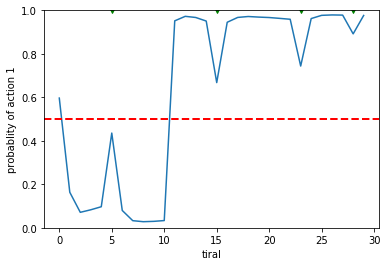

In [161]:
import matplotlib.pyplot as plt
plt.ylim((0,1))
plt.xlabel('tiral')
plt.ylabel('probablity of action 1')
plt.plot(np.arange(policy.shape[1]), policy[0, :, 1])
plt.axhline(y=0.5, linewidth=2, color = 'red', linestyle="dashed") 
plt.plot(5,1, marker="v", color='green')
plt.plot(15, 1, marker="v", color='green')
plt.plot(23, 1, marker="v", color='green')
plt.plot(28, 1, marker="v", color='green')


### On-policy simulating the model
In on-policy simulations, the actions are taken by the model. Assume that the probability of earning a reward from the first action is 0.1 and the probability of earning a reward from the second action is 0.3. We aim to simulate the model in the task for 200 trials,

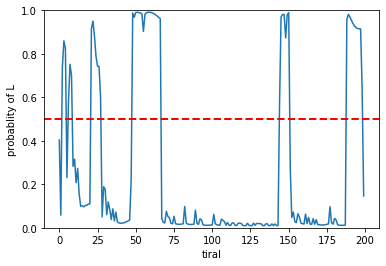

In [165]:
L_p = 0.1
R_p = 0.3

# initial state of RNN
rnn_state = np.zeros((action_reward.shape[0], n_cells,), dtype=np.float32)

# initial actions and rewards
action = np.zeros([1, 1, 2], dtype=np.float32)
reward = np.zeros((1, 1, 1), dtype=np.float32)
action_reward = Concatenate(axis=2)([reward, action])

policies = np.zeros((200,))

# getting model policy
for t in range(policies.shape[0]):
    
    # getting the policy
    rnn_state, policy = model([action_reward, rnn_state])
    policies[t] = np.squeeze(policy)[0]
    
    # gettig the last state of RNN
    rnn_state = rnn_state[:, 0, :]

    # sampling the actions and rewards
    action = np.zeros([1, 1, 2], dtype=np.float32)
    if np.random.random() < np.squeeze(policy)[0]:
        action[0, 0, 0] = 1
        if np.random.random() < L_p:
            reward = np.ones((1, 1, 1), dtype=np.float32)
        else:
            reward = np.zeros((1, 1, 1), dtype=np.float32)
    else:
        action[0, 0, 1] = 1
        if np.random.random() < R_p:
            reward = np.ones((1, 1, 1), dtype=np.float32)
        else:
            reward = np.zeros((1, 1, 1), dtype=np.float32)

    action_reward = Concatenate(axis=2)([reward, action])

# drawing policies
import matplotlib.pyplot as plt
plt.ylim((0,1))
plt.xlabel('tiral')
plt.ylabel('probablity of L')
plt.plot(np.arange(policies.shape[0]), policies)
plt.axhline(y=0.5, linewidth=2, color = 'red', linestyle="dashed") 



### See also
The model above and materials are based on [this paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006903),

* Dezfouli, A., Griffiths, K., Ramos, F., Dayan, P., & Balleine, B. W. (2019). Models that learn how humans learn: the case of decision-making and its disorders. PLoS computational biology, 15(6), e1006903.

There are two extensions to this framework. In the [first extension](https://www.biorxiv.org/content/10.1101/658252v1), instead of fitting a single model to the whole group, a different network is learned for each subject using auto-encoders. The reference is below:

* Dezfouli, A., Ashtiani, H., Ghattas, O., Nock, R., Dayan, P., & Ong, C. S. (2019). Disentangled behavioral representations. bioRxiv, 658252.

In the [second extension](https://www.biorxiv.org/content/10.1101/328849v2) to this framework, an RNN is fitted jointly to neural (fMRI) and behavioural data,

* Dezfouli, A., Morris, R., Ramos, F. T., Dayan, P., & Balleine, B. (2018). Integrated accounts of behavioral and neuroimaging data using flexible recurrent neural network models. In Advances in Neural Information Processing Systems (pp. 4228-4237).


